In [32]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode

In [20]:
def restrict(df, col, lower_limit, upper_limit):
    mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
    return df[mask]

Checking the evolution of BSE_Detailed_Output_29 with a = 1.56, essentially merges on ZAMS 

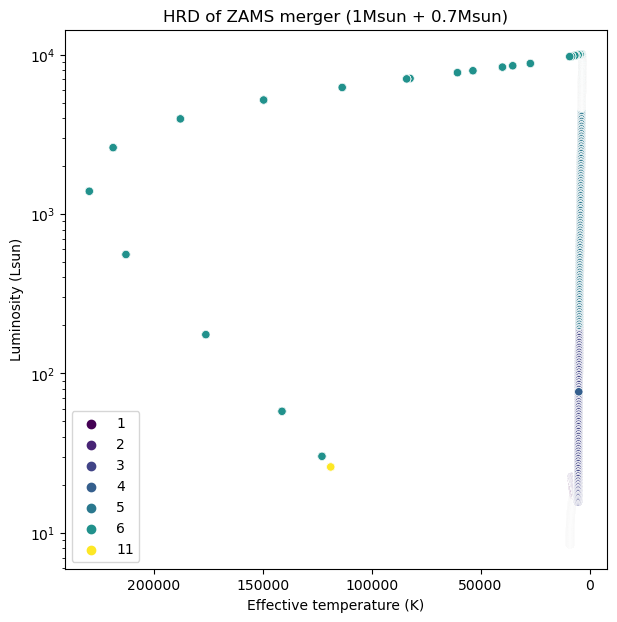

In [21]:
df = pd.read_csv('BSE_Detailed_Output_29.csv', sep = ',', header = 2)
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='        Teff(1)         ', y='     Luminosity(1)      ', hue='Stellar_Type(1)', palette='viridis', legend='full')
#plt.xlim((5000,6500))
plt.gca().invert_xaxis()
plt.title('HRD of ZAMS merger (1Msun + 0.7Msun)')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()
#plt.ylim((6e-1,2e0))

Checking the evolution of the primary in BSE_Detailed_Output_50, which experiences stable mass transfer & donates mass to its companion, becomes a He WD 

Different to Z = 0.008, Z = 0.01
HRD looks fine, the binary merges on MS

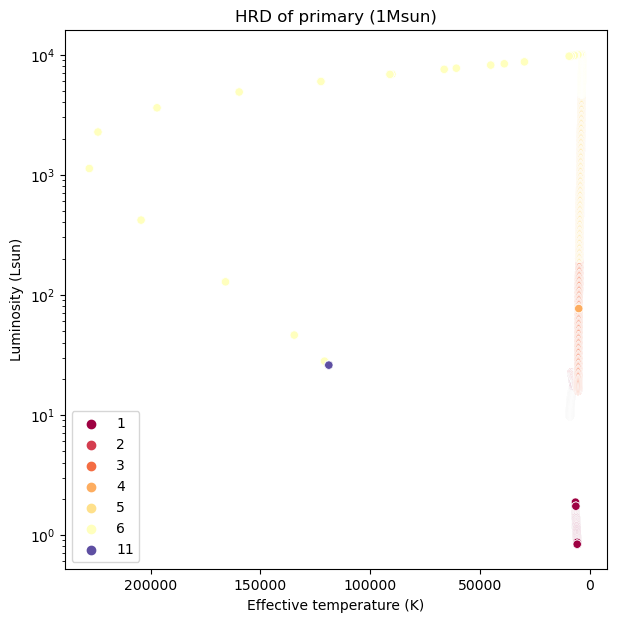

In [22]:
df = pd.read_csv('BSE_Detailed_Output_50.csv', sep = ',', header = 2)
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='        Teff(1)         ', y='     Luminosity(1)      ', hue='Stellar_Type(1)', palette='Spectral', legend='full')
#plt.xlim((5000,6500))
plt.gca().invert_xaxis()
plt.title('HRD of primary (1Msun)')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()
#plt.ylim((6e-1,2e0))

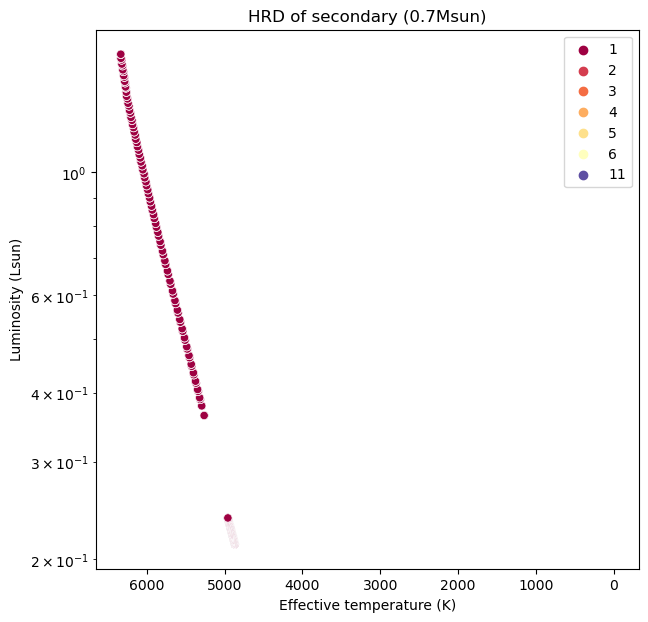

In [23]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='        Teff(2)         ', y='     Luminosity(2)      ', hue='Stellar_Type(1)', palette='Spectral', legend='full')
plt.gca().invert_xaxis()
plt.title('HRD of secondary (0.7Msun)')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

Before I pulled from the dev repo, the plot below looked different, luminosity was increasing

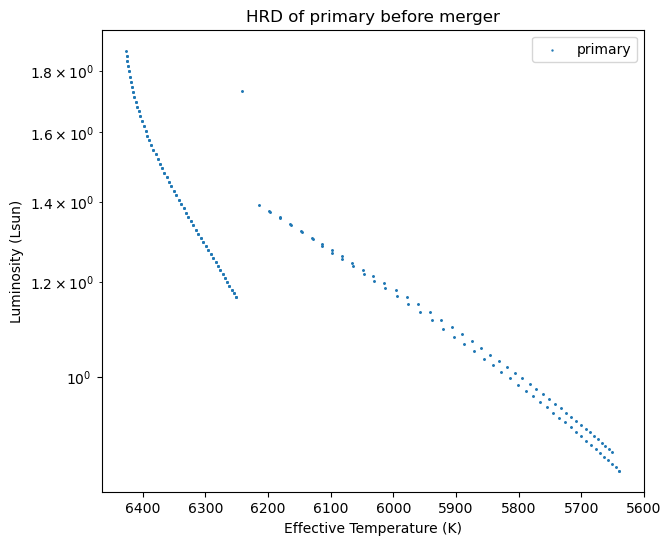

In [24]:
df1 = restrict(restrict(df, 'Stellar_Type(1)', 0, 1), 'Stellar_Type(2)', 0, 1) #MS stars only
plt.figure(figsize=(7,6))
plt.scatter(df1['        Teff(1)         '], df1['     Luminosity(1)      '], s = 0.5, label = 'primary')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.title('HRD of primary before merger')
plt.legend()

In [47]:
M1_init = 1 #Msun, primary
M2_init = 0.7 #Msun, secondary

RLOF = pd.read_csv(r'\\wsl.localhost\Ubuntu\home\minjih\2024\Honours\COMPAS\src\Z_0.004\BSE_RLOF.csv', sep = ',', header = 2)
nuclear_0 = []
thermal_0 = []

nuclear_1 = []
thermal_1 = []

ZAMS_merger_a = []
overcontact_a = []
MS_merger_a = []
beyond_MS_merger_a = []
no_merger_a = []
MS_MT_a = []
non_MS_MT_a = []
no_MT_a = []
MS_types = [0,1]

SP = pd.read_csv(r'\\wsl.localhost\Ubuntu\home\minjih\2024\Honours\COMPAS\src\Z_0.004\BSE_System_Parameters.csv', sep = ',', header = 2)
#SP = pd.read_csv(r'/home/minjihkim/COMPAS/src/COMPAS_Output/BSE_System_Parameters.csv', sep = ',', header = 2)

In [48]:
def record_MT_timescale(seed, a_0):
    try:
        MT_timescale_0 = RLOF[RLOF['    SEED    '] == seed]['MassTransferTimescale'].values[0]
    except IndexError:
        MT_timescale_0 = -1  

    if int(MT_timescale_0) == 1:
        nuclear_0.append(a_0)
    elif int(MT_timescale_0) == 2:
        thermal_0.append(a_0)

    MT_timescales = RLOF[RLOF['    SEED    '] == seed]['MassTransferTimescale'].values
    if len(MT_timescales) > 0:    
        majority_value, _ = mode(MT_timescales, keepdims=False)
    else:
        majority_value = -1  

    if majority_value == 1:
        nuclear_1.append(a_0)
    elif int(MT_timescale_0) == 2:
        thermal_1.append(a_0)

In [49]:
for n in range(0,100):
    df = pd.read_csv('BSE_Detailed_Output_'+str(n)+'.csv', sep = ',', header = 2)   

    M1_0 = float(df['        Mass(1)         '][0])
    M2_0 = float(df['        Mass(2)         '][0])
    a_0 = float(SP['   SemiMajorAxis@ZAMS   '][n])

    df_seed = int(df['    SEED    '][0])    
    record_MT_timescale(df_seed, a_0)

    if M1_0 > M1_init:
        ZAMS_merger_a.append(a_0)
    elif M1_0 == M2_0 and M1_0 == (M1_init+M2_init)/2:
        overcontact_a.append(a_0)
    else:
        merged = False
        MT = False

        for i in range(df.shape[0]):
            type2 = int(df['Stellar_Type(2)'][i])
            type1 = int(df['Stellar_Type(1)'][i])
            if type2 == 15: #mass-less remnant
                if type1 in MS_types:
                    MS_merger_a.append(a_0)
                else:
                    beyond_MS_merger_a.append(a_0)
                merged = True
                break

            if not MT and int(df['MT_History'][i]): #if != 0, there was a mass transfer
                if type1 in MS_types:
                    MS_MT_a.append(a_0)
                else:
                    non_MS_MT_a.append(a_0)
                MT = True
                
        if not merged:
            no_merger_a.append(a_0)
        if not MT:
            no_MT_a.append(a_0)

MT_History:
- NO MASS TRANSFER = 0
- MASS TRANSFER STABLE STAR1 -> STAR2 = 1
- MASS TRANSFER STABLE STAR2 -> STAR1 = 2
- MASS TRANSFER COMMON ENVELOPE STAR1 -> STAR2 = 3
- MASS TRANSFER COMMON ENVELOPE STAR2 -> STAR1 = 4
- MASS TRANSFER COMMON ENVELOPE DOUBLE CORE = 5
- MASS TRANSFER -> MERGER = 6

Initial semi-major axis resolution:

From 0.00001 to 1 AU = 0.01 AU

From 1 AU to 10 AU = 1 AU

In [27]:
def AU_to_Rsol(a1_AU, a2_AU):
    a1_Rsol = round(a1_AU*214.9394693836, 4)
    a2_Rsol = round(a2_AU*214.9394693836, 4)
    return str(a1_Rsol) + " to " + str(a2_Rsol) + " Rsol"

In [28]:
lists = [ZAMS_merger_a, overcontact_a, MS_merger_a, beyond_MS_merger_a, MS_MT_a, non_MS_MT_a, no_merger_a, no_MT_a]
descriptions = ["ZAMS merger:", "Overcontact binaries at ZAMS:", "MS merger (excluding ZAMS merger and overcontact binaries):", 
                "Merger following Cases B and C:", "Mass transfer from MS donor:", "Mass transfer from non-MS donor:", "No merger throughout the evolution:", 
                "No mass transfer throughout the evolution:"]

print("Initial (i.e. ZAMS) semi-major axis for: ")
for i in range(len(lists)):
    if lists[i] != []:
        print(descriptions[i], lists[i][0], "to", lists[i][-1], "AU   or  ", AU_to_Rsol(lists[i][0], lists[i][-1]))

Initial (i.e. ZAMS) semi-major axis for: 
ZAMS merger: 1e-05 to 0.00726 AU   or   0.0021 to 1.5605 Rsol
Overcontact binaries at ZAMS: 0.00751 to 0.01026 AU   or   1.6142 to 2.2053 Rsol
MS merger (excluding ZAMS merger and overcontact binaries): 0.01051 to 0.01351 AU   or   2.259 to 2.9038 Rsol
Mass transfer from MS donor: 0.01051 to 0.02376 AU   or   2.259 to 5.107 Rsol
Mass transfer from non-MS donor: 0.02401 to 0.02476 AU   or   5.1607 to 5.3219 Rsol
No merger throughout the evolution: 0.01376 to 0.02476 AU   or   2.9576 to 5.3219 Rsol


Compared to Z = 0.008:

- overall similar
- ZAMS merger: upper limit 0.05 Rsol higher
- Overcontact binaries at ZAMS: lower limit 0.05 Rsol higher, upper limit same
- MS merger: lower limit same, upper limit 1.4 Rsol smaller
- Mass transfer from MS donor: lower limit same, upper limit 0.6 Rsol higher
- Mass transfer from non-MS donor: lower limit 0.6 Rsol higher, upper limit same
- No merger throughout the evolution: lower limit 0.3 Rsol higher, upper limit same

Overall, looks reasonable, seems to work.

In [51]:
lists = [nuclear_0, thermal_0, nuclear_1, thermal_1]
descriptions = ["Nuclear timescale mass transfer (initially):", 
                "Thermal timescale mass transfer (initially):",
                "Nuclear timescale mass transfer (majority):", 
                "Thermal timescale mass transfer (majority):"]
print("Initial (i.e. ZAMS) semi-major axis for: ")
for i in range(len(lists)):
    if lists[i] != []:
        print(descriptions[i], lists[i][0], "to", lists[i][-1], "AU   or  ", AU_to_Rsol(lists[i][0], lists[i][-1]))

Initial (i.e. ZAMS) semi-major axis for: 
Thermal timescale mass transfer (initially): 0.01051 to 0.02476 AU   or   2.259 to 5.3219 Rsol
Nuclear timescale mass transfer (majority): 0.01051 to 0.01726 AU   or   2.259 to 3.7099 Rsol
Thermal timescale mass transfer (majority): 0.01426 to 0.02476 AU   or   3.065 to 5.3219 Rsol


All MS mergers start off with thermal MT timescale (i.e. first row), but the following evolution is all in nucelar timescale. Last timestep is dynamical. 

Some MT from MS donor switch from thermal to nuclear, others, ~ 3 to 5 Rsol, stay mostly thermal.